In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import random

In [2]:
#Load the data set where we have data at 0.5 Hz
person = pd.read_excel('merge2sNWL.xlsx')
person.head()

,Unnamed: 0,Participant,HR,EDA,Temp,Label,EDA_ene
0,0.0,2.0,115.750,0.618226,34.76,0.0,0.764408
1,1.0,2.0,93.125,0.603330,34.80,0.0,0.728258
2,2.0,2.0,84.115,0.494090,34.84,0.0,0.488904
3,3.0,2.0,78.915,0.459171,34.83,0.0,0.421726
4,4.0,2.0,76.135,0.442353,34.76,0.0,0.391404


In [3]:
#Then we choose the participant
x = person[person['Participant']==2]
x.head()

,Unnamed: 0,Participant,HR,EDA,Temp,Label,EDA_ene
0,0.0,2.0,115.750,0.618226,34.76,0.0,0.764408
1,1.0,2.0,93.125,0.603330,34.80,0.0,0.728258
2,2.0,2.0,84.115,0.494090,34.84,0.0,0.488904
3,3.0,2.0,78.915,0.459171,34.83,0.0,0.421726
4,4.0,2.0,76.135,0.442353,34.76,0.0,0.391404


In [4]:
#Verfiring that dataset does not have null
x.isnull().sum()

Unnamed: 0     0
Participant    0
HR             0
EDA            0
Temp           0
Label          0
EDA_ene        0
dtype: int64

In [5]:
D_Lstm = x.drop(['Participant','Unnamed: 0', 'EDA_ene'], axis = 1)
D_Lstm.head()
print(len(D_Lstm))

958


In [6]:
D_Lstm.head()

,HR,EDA,Temp,Label
0,115.750,0.618226,34.76,0.0
1,93.125,0.603330,34.80,0.0
2,84.115,0.494090,34.84,0.0
3,78.915,0.459171,34.83,0.0
4,76.135,0.442353,34.76,0.0


In [11]:
# tensorflow imports
from tensorflow import keras
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [7]:
n_tr, n_val = int(0.6*len(D_Lstm)), int(0.25*len(D_Lstm))
n_te = len(D_Lstm) - n_tr - n_val
print('Samples for training: %d; validation: %d; test: %d' % (n_tr, n_val, n_te))

Samples for training: 574; validation: 239; test: 145


In [8]:
# Get the data from the dataframe (dropping date column)
data = D_Lstm.iloc[:, :-1].values
print(data.shape)

# We need to normalise our time series. Calculate mean and std from TRAINING DATA ONLY. 
# We'll use it on the validation and test sets.
#data[:n_tr, :-1]
mean_tr = data[:n_tr, :].mean(axis=0)
std_tr = data[:n_tr, :].std(axis=0)
data[:, :] = (data[:, :] - mean_tr) / std_tr


y = D_Lstm['Label'].values.reshape(-1, 1)



(958, 3)


In [9]:
# We'll use a Dataset from keras to pass our data
sampling_rate = 1  # we keep all data points
sequence_length = 5  # 10s to predict stress 
delay = sampling_rate * sequence_length  # the target is the day after the end of the sequence
batch_size = 30 

In [12]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=0, end_index=n_tr  
    )

val_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr, end_index=n_tr+n_val  
    )

test_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr+n_val  
    )

for X, target in train_dataset:
    print("X shape:", X.shape)
    print("target shape:", target.shape)

    break  # so we only print once

X shape: (30, 5, 3)
target shape: (30, 1)


In [13]:
model_lstm1 = models.Sequential()
model_lstm1.add(layers.LSTM(40, input_shape=(sequence_length, len(D_Lstm.columns)-1)))
model_lstm1.add(layers.Dense(1))

model_lstm1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                7040      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 7,081
Trainable params: 7,081
Non-trainable params: 0
_________________________________________________________________


In [14]:
n_epochs = 40

In [16]:
model_lstm1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_lstm1 = model_lstm1.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

Epoch 1/40
19/19 [==============================] - 3s 44ms/step - loss: 0.0623 - mae: 0.1669 - val_loss: 1.4336 - val_mae: 0.9968
Epoch 2/40
19/19 [==============================] - 0s 15ms/step - loss: 0.0577 - mae: 0.1660 - val_loss: 1.4284 - val_mae: 0.9983
Epoch 3/40
19/19 [==============================] - 1s 28ms/step - loss: 0.0571 - mae: 0.1634 - val_loss: 1.4299 - val_mae: 0.9993
Epoch 4/40
19/19 [==============================] - 0s 24ms/step - loss: 0.0568 - mae: 0.1630 - val_loss: 1.4278 - val_mae: 0.9992
Epoch 5/40
19/19 [==============================] - 0s 22ms/step - loss: 0.0565 - mae: 0.1626 - val_loss: 1.4243 - val_mae: 0.9988
Epoch 6/40
19/19 [==============================] - 1s 26ms/step - loss: 0.0563 - mae: 0.1622 - val_loss: 1.4200 - val_mae: 0.9983
Epoch 7/40
19/19 [==============================] - 0s 15ms/step - loss: 0.0560 - mae: 0.1618 - val_loss: 1.4151 - val_mae: 0.9975
Epoch 8/40
19/19 [==============================] - 0s 15ms/step - loss: 0.0558 - m

In [17]:
results = model_lstm1.predict(test_dataset)

5/5 [==============================] - 1s 6ms/step


In [18]:
results

array([[1.5343981],
       [1.5382123],
       [1.5490341],
       [1.559813 ],
       [1.5767624],
       [1.5942922],
       [1.5886354],
       [1.6012454],
       [1.5953315],
       [1.5915997],
       [1.5996189],
       [1.6069918],
       [1.6227566],
       [1.6201341],
       [1.6116915],
       [1.6065089],
       [1.5755966],
       [1.5231428],
       [1.4986731],
       [1.4851482],
       [1.4591309],
       [1.508615 ],
       [1.5412608],
       [1.536304 ],
       [1.5312207],
       [1.5218444],
       [1.5254052],
       [1.529503 ],
       [1.5346651],
       [1.5690448],
       [1.5923426],
       [1.6075243],
       [1.6288335],
       [1.6447773],
       [1.641082 ],
       [1.6247003],
       [1.6119913],
       [1.6042864],
       [1.5910084],
       [1.5953394],
       [1.6129706],
       [1.5883651],
       [1.5685939],
       [1.5716418],
       [1.532244 ],
       [1.5164031],
       [1.5846875],
       [1.6563461],
       [1.7216127],
       [1.8167479],


In [19]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

958
145


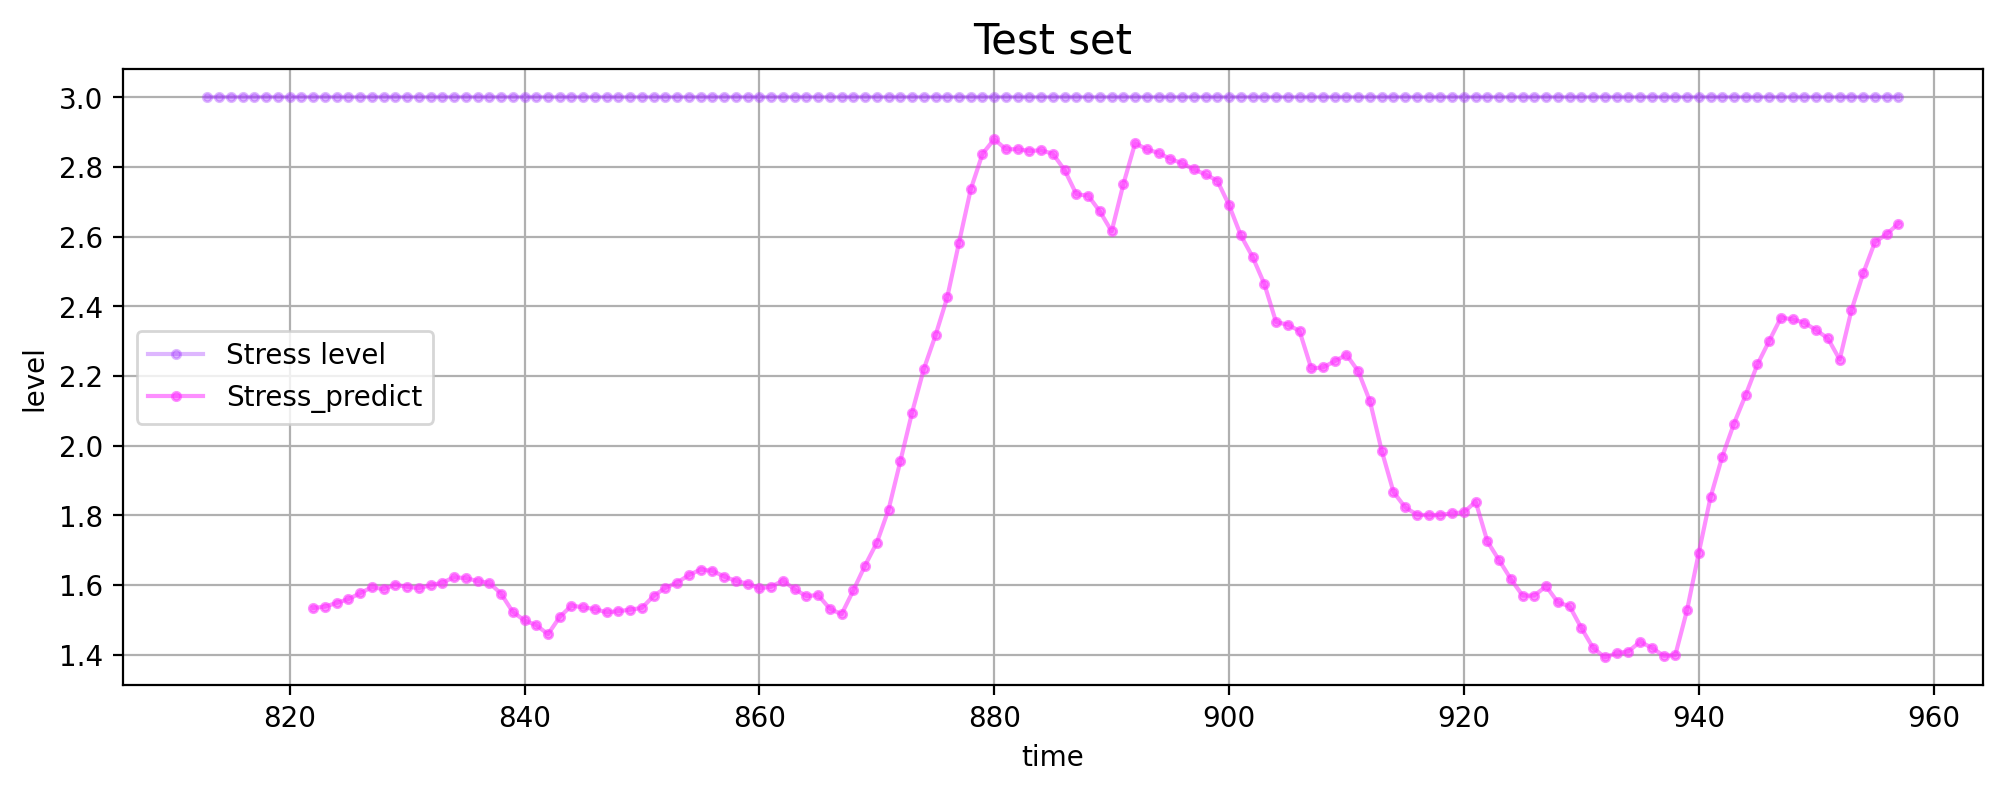

In [28]:
#Plotting predict data and  out
xx=x.index
t=xx.to_numpy()
print(len(t))
stress = x.values.T[5]# 
print(len(stress[:145]))
plt.figure(figsize=(12,4), dpi=200)
plt.plot(t[813:], stress[813:],'.-',color="#A233FF",alpha=0.35,label="Stress level")
plt.plot(t[822:], results[:],'.-',color="#FD33FF",alpha=0.55,label="Stress_predict")
plt.title("Test set",fontsize=15)
plt.legend()
plt.xlabel("time")
plt.ylabel("level")
plt.grid('True')
plt.show()

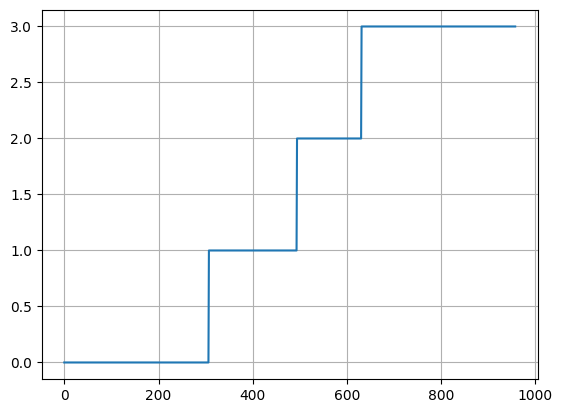

In [29]:
plt.plot(D_Lstm['Label'])
plt.grid()